/tmp/ipykernel_71735/3164196466.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  U[i-1] = u


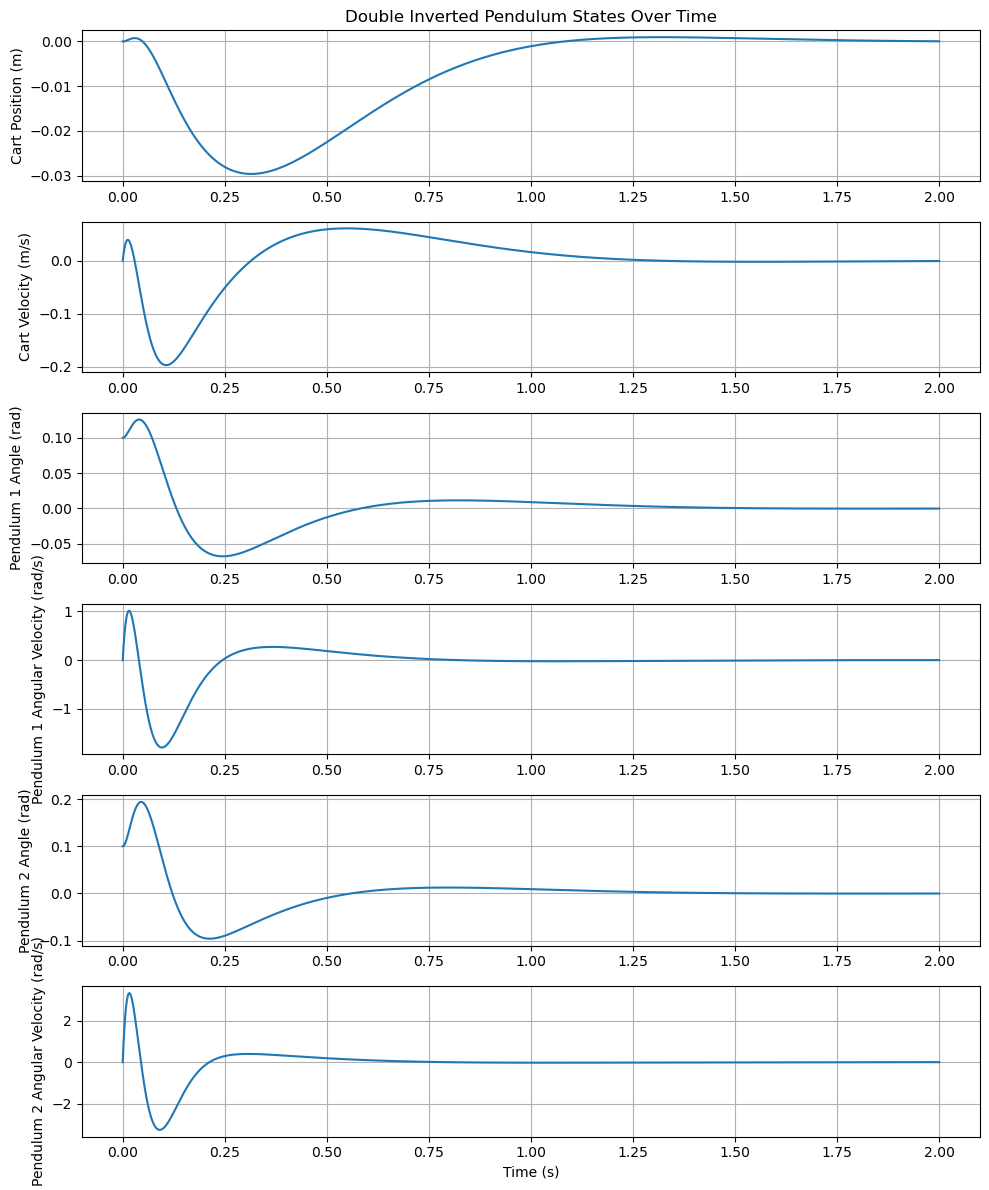

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# System parameters (example values, replace with your own)
M = 0.3163     # Mass of cart
m1 = 0.0318    # Mass of pendulum 1
m2 = 0.0085    # Mass of pendulum 2
l1 = 0.316/2   # Length of pendulum 1
l2 = 0.079/2   # Length of pendulum 2
g = 9.81       # Gravity
I1 = 0.0085*(0.0098**2+0.0379**2)/12 + m1*((l1*2)**2)/3
I2 = 0.0085*(0.0098**2+0.0379**2)/12 + m2*((l2*2)**2)/3

# Damping
alpha = 12.2     # Carriage Slope
xdotss = 0.4852  # Terminal Velocity

a1 = 0.0185
a2 = 0.012

c = (M+m1+m2)*g*np.sin(alpha*np.pi/180)/xdotss  # Damping / Viscous Friction
c1 = 2*a1*I1 # Viscous friction of pendulum 1 (rotational)
c2 = 2*a2*I2 # Viscous friction of pendulum 2 (rotational)

# Linearized state-space matrices for double inverted pendulum (about upright)
M = np.array([[M + m1 + m2, m1*l1, m2*l2],
              [-m1*l1, -m1*l1**2 + I1, 0],
              [-m2*l2, 0, -m2*l2**2 + I2]])

inv_M = np.linalg.inv(M)

A = np.array([[0, 1, 0, 0, 0, 0],
              [0, -inv_M[0,0]*c, inv_M[0,1]*m1*l1*g, inv_M[0,1]*c1, inv_M[0,2]*m2*l2*g, inv_M[0,2]*c2],
              [0, 0, 0, 1, 0, 0],
              [0, -inv_M[1,0]*c, inv_M[1,1]*m1*l1*g, inv_M[1,1]*c1, inv_M[1,2]*m2*l2*g, inv_M[1,2]*c2],
              [0, 0, 0, 0, 0, 1],
              [0, -inv_M[2,0]*c, inv_M[2,1]*m1*l1*g, inv_M[2,1]*c1, inv_M[2,2]*m2*l2*g, inv_M[2,2]*c2]])

B = np.array([[0],
              [inv_M[0,0]],
              [0],
              [inv_M[1,0]],
              [0],
              [inv_M[2,0]]])

# LQR design
Q = np.diag([1000, 0, 100, 0, 100, 0])
R = np.array([[1]])

# Solve Riccati equation for LQR
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ B.T @ P

# Simulation parameters
T = np.linspace(0, 2, 2000)
dt = T[1] - T[0]
X = np.zeros((6, len(T)))
X[:,0] = [0, 0, 0.1, 0, 0.1, 0]  # Small initial angles

U = np.zeros(len(T))

def lqr_control(x):
    return -K @ x

# Simulate
for i in range(1, len(T)):
    u = lqr_control(X[:,i-1])
    U[i-1] = u
    x_dot = A @ X[:,i-1] + B.flatten() * u
    X[:,i] = X[:,i-1] + x_dot * dt

# Plot results
labels = ['Cart Position (m)', 'Cart Velocity (m/s)', 
          'Pendulum 1 Angle (rad)', 'Pendulum 1 Angular Velocity (rad/s)',
          'Pendulum 2 Angle (rad)', 'Pendulum 2 Angular Velocity (rad/s)']
plt.figure(figsize=(10, 12))
for idx in range(6):
    plt.subplot(6,1,idx+1)
    plt.plot(T, X[idx,:])
    plt.ylabel(labels[idx])
    if idx == 0:
        plt.title('Double Inverted Pendulum States Over Time')
    if idx == 5:
        plt.xlabel('Time (s)')
    plt.grid(True)
plt.tight_layout()
plt.show()

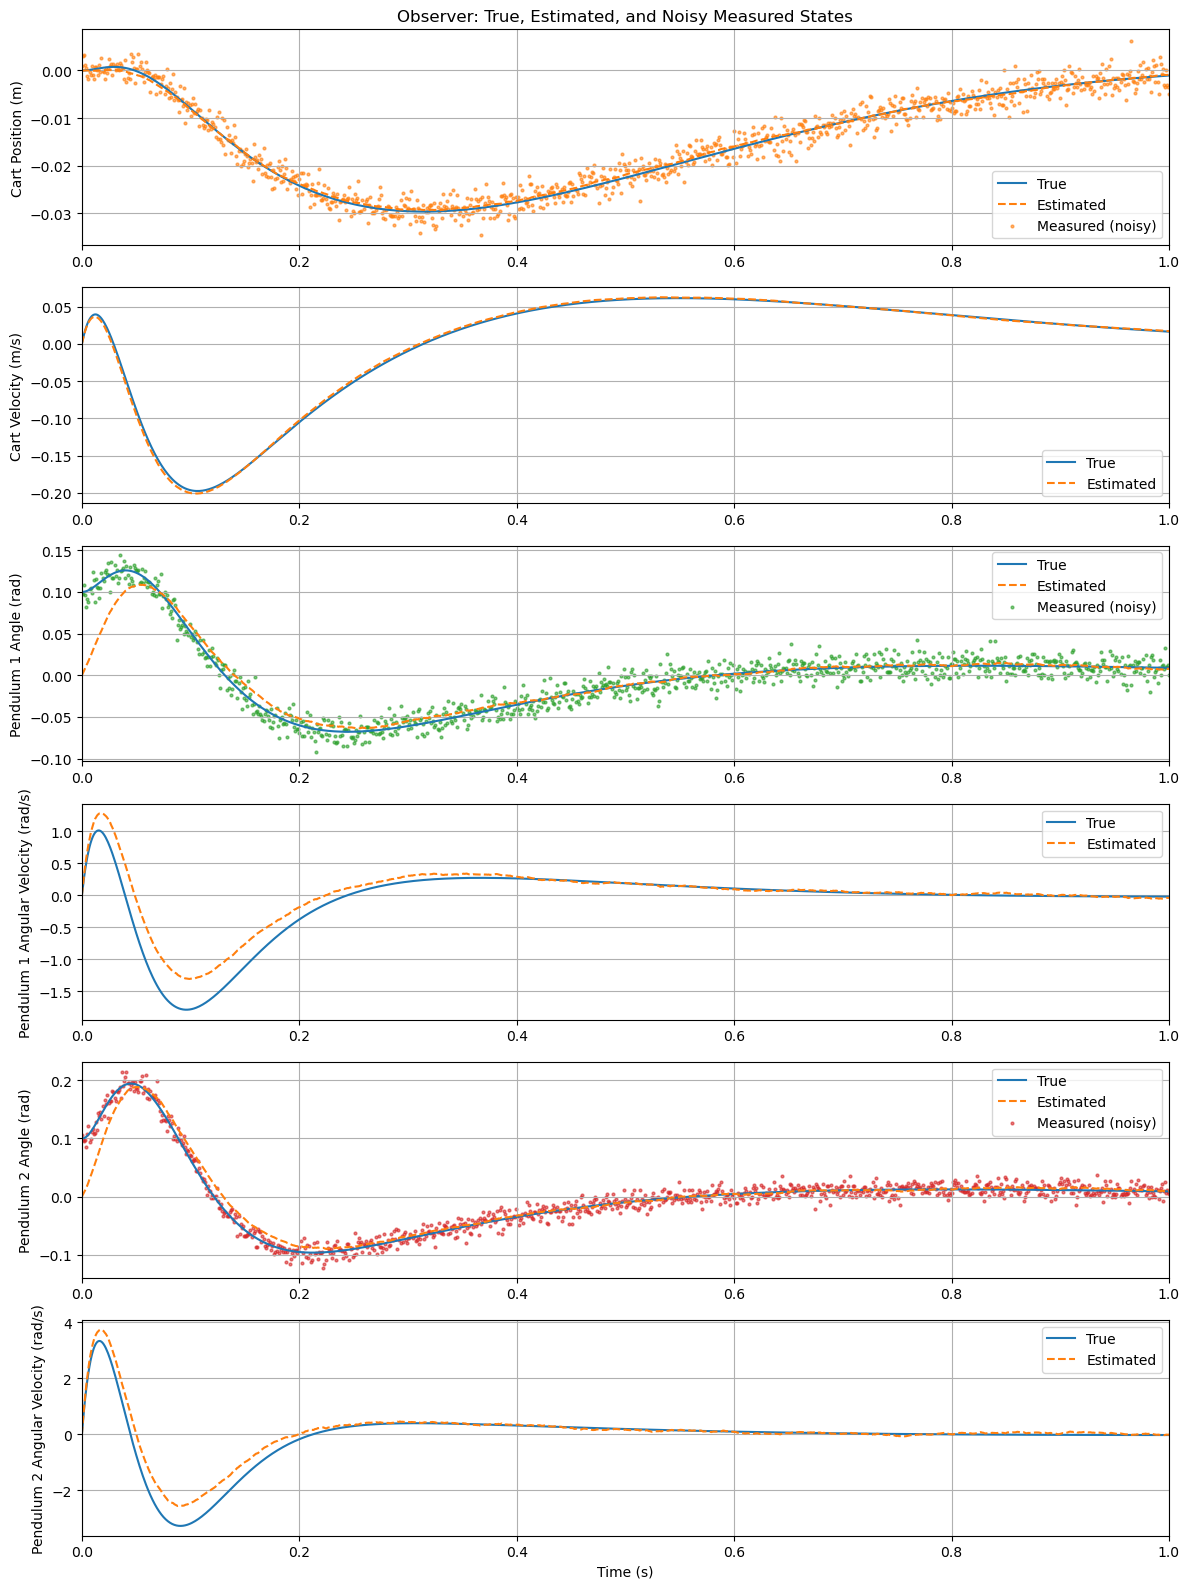

In [11]:
from scipy.signal import place_poles

# Define the output matrix C for measurable states: x (cart position), theta1, theta2
C = np.array([
    [1, 0, 0, 0, 0, 0],  # x
    [0, 0, 1, 0, 0, 0],  # theta1
    [0, 0, 0, 0, 1, 0]   # theta2
])

# Place observer poles (choose them faster than closed-loop poles)
# For simplicity, place all observer poles at -10
observer_poles = np.array([-10, -11, -12, -13, -14, -15])

# Compute observer gain L
L = place_poles(A.T, C.T, observer_poles).gain_matrix.T

# Simulate observer for the double inverted pendulum

np.random.seed(42)  # For reproducibility

# Measurement noise standard deviations for x, theta1, theta2
noise_std = [0.002, 0.01, 0.01]

# Initial observer state (can be zeros)
X_hat = np.zeros((6, len(T)))
Y = np.zeros((3, len(T)))    # Noisy measured outputs

for i in range(1, len(T)):
    # Output measurement (x, theta1, theta2) with noise
    true_meas = C @ X[:, i-1]
    noise = np.array([np.random.normal(0, noise_std[0]),
                      np.random.normal(0, noise_std[1]),
                      np.random.normal(0, noise_std[2])])
    Y[:, i-1] = true_meas + noise
    # Observer update
    x_hat_dot = (A @ X_hat[:, i-1] + B.flatten() * U[i-1] +
                 L @ (Y[:, i-1] - C @ X_hat[:, i-1]))
    X_hat[:, i] = X_hat[:, i-1] + x_hat_dot * dt

# Plot true vs estimated states and noisy measurements for measured states
plt.figure(figsize=(12, 16))
labels = ['Cart Position (m)', 'Cart Velocity (m/s)', 
          'Pendulum 1 Angle (rad)', 'Pendulum 1 Angular Velocity (rad/s)',
          'Pendulum 2 Angle (rad)', 'Pendulum 2 Angular Velocity (rad/s)']
measured_indices = [0, 2, 4]
measured_colors = ['tab:orange', 'tab:green', 'tab:red']

for idx in range(6):
    plt.subplot(6, 1, idx + 1)
    plt.plot(T, X[idx, :], label='True')
    plt.plot(T, X_hat[idx, :], '--', label='Estimated')
    if idx in measured_indices:
        meas_idx = measured_indices.index(idx)
        plt.scatter(T, Y[meas_idx, :], s=4, marker='o', color=measured_colors[meas_idx], label='Measured (noisy)', alpha=0.6)
    plt.ylabel(labels[idx])
    plt.xlim(0, 1)
    if idx == 0:
        plt.title('Observer: True, Estimated, and Noisy Measured States')
    if idx == 5:
        plt.xlabel('Time (s)')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()